In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function, division

from matplotlib import pyplot as plt
import pandas
import src
import gensim
import os
import os.path
import csv
import functools
from operator import itemgetter

INFO:gensim.corpora.sharded_corpus:Could not import Theano, will use standard float for default ShardedCorpus dtype.
2015-12-13 15:27:00 twoism gensim.corpora.sharded_corpus[5870] INFO Could not import Theano, will use standard float for default ShardedCorpus dtype.
INFO:summa.preprocessing.cleaner:'pattern' package not found; tag filters are not available for English
2015-12-13 15:27:00 twoism summa.preprocessing.cleaner[5870] INFO 'pattern' package not found; tag filters are not available for English


In [3]:
def get_n_closest(l, avg, n):
    diffs = [abs(avg - item) for item in list(l)]
    diffs = sorted(enumerate(diffs), key=lambda x: x[1])
    return [x for x, y in diffs[:n]]    

In [4]:
rankfiles = dict()
runsloc = '/mnt/6000/thesis-data/runs'
for dirpath, dirname, filenames in os.walk(runsloc):
    for filename in filenames:
        if filename.endswith("-ranks.csv.gz"):
            _, num, _, name, version = dirpath.replace(runsloc, '').split('/')
            if name not in rankfiles:
                rankfiles[name] = {'changeset': {'feature_location': list(),
                                                 'triage': list()},
                                   'release': {'feature_location': list(),
                                               'triage': list()},
                                  }
                
            parts = filename.split('-')
            rankfiles[name][parts[0]][parts[1]].append((int(num), os.path.join(dirpath, filename)))

for name, source in rankfiles.items():
    for source, exps in source.items():
        for exp, filenames in exps.items():
            rankfiles[name][source][exp] = [x for _, x in sorted(filenames)]

In [5]:
rankfiles

{'bookkeeper': {'changeset': {'feature_location': ['/mnt/6000/thesis-data/runs/1/data/bookkeeper/v4.3.0/changeset-feature_location-lda-true-true-false-true-batch-0.002-0.5-0.002-1000-1000-500-1.0-1-file-ranks.csv.gz',
    '/mnt/6000/thesis-data/runs/2/data/bookkeeper/v4.3.0/changeset-feature_location-lda-true-true-false-true-batch-0.002-0.5-0.002-1000-1000-500-1.0-1-file-ranks.csv.gz',
    '/mnt/6000/thesis-data/runs/3/data/bookkeeper/v4.3.0/changeset-feature_location-lda-true-true-false-true-batch-0.002-0.5-0.002-1000-1000-500-1.0-1-file-ranks.csv.gz',
    '/mnt/6000/thesis-data/runs/4/data/bookkeeper/v4.3.0/changeset-feature_location-lda-true-true-false-true-batch-0.002-0.5-0.002-1000-1000-500-1.0-1-file-ranks.csv.gz',
    '/mnt/6000/thesis-data/runs/5/data/bookkeeper/v4.3.0/changeset-feature_location-lda-true-true-false-true-batch-0.002-0.5-0.002-1000-1000-500-1.0-1-file-ranks.csv.gz',
    '/mnt/6000/thesis-data/runs/6/data/bookkeeper/v4.3.0/changeset-feature_location-lda-true-true-

In [6]:
df = pandas.DataFrame()
for name, source in rankfiles.items():
    for source, exps in source.items():
        for exp, filenames in exps.items():
            mrr = list()
            for each in filenames:
                try:
                    data = pandas.read_csv(each)
                except Exception:
                    print("error reading %s" % each)
                    continue
                mrr.append(src.utils.calculate_mrr(list(data.groupby("id")["rank"].min())))
                
                if len(data[data["distance"] == 1.0]):
                    print(each)
        
            mrr = pandas.Series(mrr)       
            df = df.append(
              {'subject': name, 
               'source': source,
               'experiment': exp,
               'std': mrr.std(),
               'max-min': mrr.max() - mrr.min(),
               'max': mrr.max(),
               'median': mrr.median(),
               'min': mrr.min(),
               'count': mrr.count(),
               'raw': mrr,
              }, ignore_index=True)

In [7]:
df

,count,experiment,max,max-min,median,min,raw,source,std,subject
0,50,feature_location,0.368762,0.095590,0.312443,0.273172,0 0.293907 1 0.295913 2 0.294065 3...,release,0.020992,openjpa
1,50,triage,0.336067,0.083905,0.293648,0.252162,0 0.312537 1 0.271933 2 0.277477 3...,release,0.018056,openjpa
2,50,feature_location,0.383814,0.084180,0.329169,0.299635,0 0.378652 1 0.365795 2 0.320250 3...,changeset,0.021415,openjpa
3,50,triage,0.396865,0.115202,0.344560,0.281663,0 0.350950 1 0.349138 2 0.330240 3...,changeset,0.023844,openjpa
4,50,feature_location,0.666961,0.049672,0.644617,0.617289,0 0.665236 1 0.624601 2 0.635652 3...,release,0.013105,zookeeper
5,50,triage,0.543743,0.059899,0.511668,0.483843,0 0.506386 1 0.504387 2 0.511342 3...,release,0.013244,zookeeper
6,50,feature_location,0.664894,0.057573,0.633545,0.607321,0 0.634202 1 0.632348 2 0.664894 3...,changeset,0.014654,zookeeper
7,50,triage,0.388732,0.062004,0.366468,0.326728,0 0.326728 1 0.361478 2 0.360082 3...,changeset,0.014989,zookeeper
8,50,feature_location,0.482366,0.069649,0.449593,0.412717,0 0.457013 1 0.432943 2 0.439077 3...,release,0.015429,pig
9,50,triage,0.619278,0.098386,0.575613,0.520892,0 0.568820 1 0.561572 2 0.550892 3...,release,0.021537,pig


In [8]:

for plotname, indices in df.groupby(["source", "experiment"]).groups.items():
    source, exp = plotname
    for s, each in enumerate(indices):
        row = df.ix[each]
        c = row.raw.ix[get_n_closest(row.raw, row.raw.mean(), 1)]
        run = c.index[0]
        mrr = c.values[0]
        print(row.subject, source, exp, run, mrr, rankfiles[row.subject][source][exp][run - 1])

openjpa release triage 35 0.293236685075 /mnt/6000/thesis-data/runs/35/data/openjpa/v2.3.0/release-triage-lda-batch-0.002-0.5-0.002-1000-1000-500-1.0-1-file-ranks.csv.gz
zookeeper release triage 34 0.511574443558 /mnt/6000/thesis-data/runs/34/data/zookeeper/v3.5.0/release-triage-lda-batch-0.002-0.5-0.002-1000-1000-500-1.0-1-file-ranks.csv.gz
pig release triage 46 0.573152647341 /mnt/6000/thesis-data/runs/46/data/pig/v0.14.0/release-triage-lda-batch-0.002-0.5-0.002-1000-1000-500-1.0-1-file-ranks.csv.gz
mahout release triage 25 0.276849978122 /mnt/6000/thesis-data/runs/25/data/mahout/v0.10.0/release-triage-lda-batch-0.002-0.5-0.002-1000-1000-500-1.0-1-file-ranks.csv.gz
tika release triage 3 0.520645645646 /mnt/6000/thesis-data/runs/3/data/tika/v1.8/release-triage-lda-batch-0.002-0.5-0.002-1000-1000-500-1.0-1-file-ranks.csv.gz
bookkeeper release triage 2 0.684552845528 /mnt/6000/thesis-data/runs/2/data/bookkeeper/v4.3.0/release-triage-lda-batch-0.002-0.5-0.002-1000-1000-500-1.0-1-file-ran

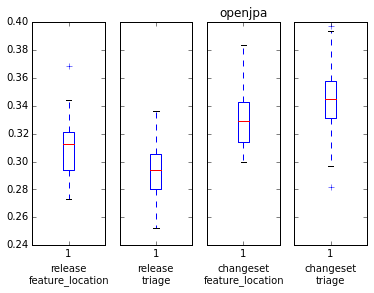

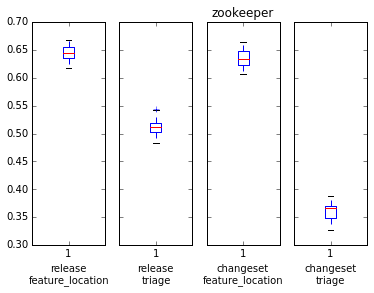

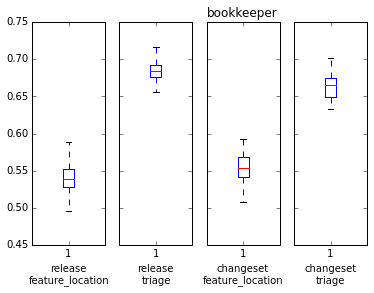

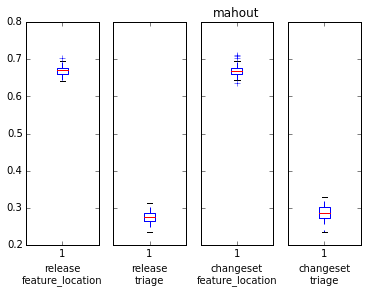

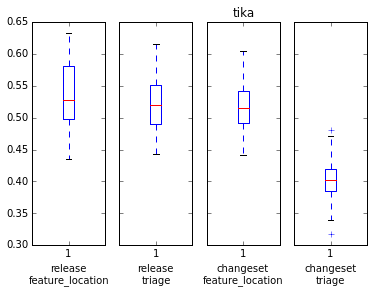

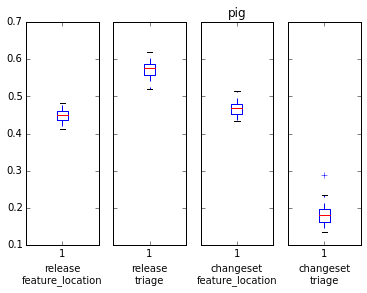

In [9]:
for plotname, indices in df.groupby(["subject"]).groups.items():
    fig, axarr = plt.subplots(1, 4, sharey=True)
    axarr[2].set_title(plotname)
    for s, each in enumerate(indices):
        exp = df.ix[each]
        if (exp["min"] == 1.0):
            continue
        axarr[s].boxplot(exp.raw)
        axarr[s].set_xlabel(exp.source + "\n" + exp.experiment)
    plt.show()